In [1]:
import hgfp
import torch
import dgl
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from matplotlib import pyplot as plt
from IPython.display import clear_output

RDKit WARNING: [15:19:55] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
element_to_idx = {b'BR': 0, b'C': 1, b'C2': 2, b'CA': 3, b'CB': 4, b'CC': 5, b'CJ': 6, b'CL': 7, b'CM': 8, b'CP': 9, b'CR': 10, b'CT': 11, b'CW': 12, b'Cstar': 13, b'F': 14, b'H': 15, b'H1': 16, b'H2': 17, b'H3': 18, b'H4': 19, b'H5': 20, b'HA': 21, b'HC': 22, b'HO': 23, b'HP': 24, b'HX': 25, b'I': 26, b'N': 27, b'N2': 28, b'N3': 29, b'NA': 30, b'NB': 31, b'NC': 32, b'NL': 33, b'Nstar': 34, b'Nu': 35, b'O': 36, b'O2': 37, b'OH': 38, b'OS': 39, b'Ou': 40, b'P': 41, b'S': 42, b'SO': 43, b'Su': 44}

In [3]:
idx_to_element = {v: k.decode("utf-8") for k, v in element_to_idx.items()}

In [4]:
ds = list(hgfp.data.parm_at_Frosst.df.batched(num=100, batch_size=16))

/Users/wangy1/anaconda3/envs/env1/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [5]:
print(len(ds))

6


In [6]:
ds_tr, ds_vl, ds_te = hgfp.data.utils.split(ds, 1, 1)

In [7]:
class Classifier(torch.nn.Module):
    def __init__(self, in_dim=64, out_dim=64, n_classes=45):
        super(Classifier, self).__init__()
        self.d = torch.nn.Linear(in_dim, out_dim)
        self.c = torch.nn.Linear(out_dim, n_classes)
        
    def forward(self, x):
        y_hat = self.c(
                torch.nn.functional.tanh(
                    self.d(
                        x)))
        
        return y_hat
        
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.f_in = torch.nn.Sequential(
            torch.nn.Linear(100, 32),
            torch.nn.Tanh())
        
        self.gn0 = hgfp.models.walk_recurrent.WRGN(32)
        self.gn1 = hgfp.models.walk_recurrent.WRGN(32)
        self.gn2 = hgfp.models.walk_recurrent.WRGN(32)
        
        self.c = Classifier(32, 32, 45)
        
    def forward(self, g):
        g.nodes['g1'].data['h'] = self.f_in(g.nodes['g1'].data['h0'])
        g = self.gn0(g)
        g = self.gn1(g)
        g = self.gn2(g)
        x = g.nodes['g1'].data['h']
        x = self.c(x)
        return x
        

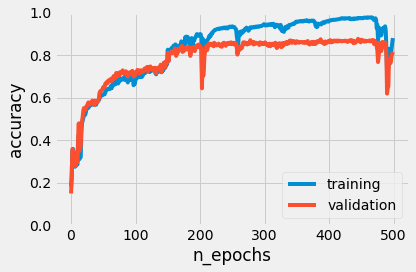

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
namespace = __import__(__name__)
net = Net()
opt = torch.optim.Adam(list(net.parameters()), 1e-3)
plt.figure()

plt.style.use('fivethirtyeight')
plt.clf()

for part in ['tr', 'vl', 'te']:
    exec('accuracy_' + part + '= []')

for _ in range(500):
    clear_output(wait=True)
    for g, y in ds_tr:
        opt.zero_grad()
        y_hat = net(g)
        loss = loss_fn(y_hat, torch.where(torch.gt(y, 0))[1])
        loss.backward()
        opt.step()

    net.eval()
    for part in ['tr', 'vl', 'te']:
        y_hat = torch.cat([torch.argmax(net(g), dim=1) for g, y in getattr(
            namespace, 'ds_' + part)], dim=0).detach().numpy()

        y = torch.cat([torch.argmax(y, dim=1) for g, y in getattr(
            namespace, 'ds_' + part)], dim=0).detach().numpy()

        getattr(namespace, 'accuracy_' + part).append(
            1 - np.divide(
                np.count_nonzero(y_hat - y),
            y_hat.shape[0]))

    net.train()


    plt.plot(accuracy_tr, label='training')
    plt.plot(accuracy_vl, label='validation')
    plt.ylim(0, 1)
    plt.legend()
    plt.ylabel('accuracy')
    plt.xlabel('n_epochs')
    plt.tight_layout()


    plt.show()

In [9]:
net.eval()
from sklearn.metrics import confusion_matrix

y_hat = torch.cat([torch.argmax(net(g), dim=1) for g, y in ds_vl+ds_te], axis=0)
y = torch.cat([torch.argmax(y, dim=1) for g, y in ds_vl+ds_te], axis=0)

print(np.count_nonzero(y - y_hat) / y_hat.shape[0])

0.18976545842217485


/Users/wangy1/anaconda3/envs/env1/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [10]:
import pandas as pd
df_cm = pd.DataFrame(confusion_matrix(y, y_hat, labels=list(range(1, 46))),
    [v for k, v in idx_to_element.items()],
    [v for k, v in idx_to_element.items()])

In [11]:
count_matrix = df_cm.values
wrong_idxs = np.stack(np.where(np.greater(count_matrix, 0)), axis=1)
wrong_idxs = wrong_idxs[wrong_idxs[:, 0] != wrong_idxs[:, 1]]
wrong_count = np.array([count_matrix[idxs[0]][idxs[1]] for idxs in wrong_idxs])
wrong_count_argsort = np.flip(np.argsort(wrong_count))
for idx in wrong_count_argsort:
    print('%s -> %s : %s'%(
        idx_to_element[wrong_idxs[idx][0]],
        idx_to_element[wrong_idxs[idx][1]],
        wrong_count[idx]))

H -> HA : 38
C2 -> BR : 7
C2 -> CA : 7
BR -> CL : 5
CT -> CB : 5
CB -> CL : 5
CB -> CT : 5
NA -> NB : 5
H1 -> H3 : 5
CP -> CA : 4
NL -> NA : 4
CP -> CT : 4
HA -> H : 3
CT -> OH : 3
CR -> CL : 3
N2 -> I : 3
CT -> CP : 3
CL -> CB : 3
NA -> P : 3
P -> NA : 3
CL -> CR : 2
CR -> CB : 2
CB -> CA : 2
CA -> C2 : 2
Cstar -> Nu : 2
CL -> C2 : 2
S -> P : 2
N -> P : 2
NB -> NA : 2
NA -> I : 2
N -> I : 2
O -> Nu : 2
N3 -> NL : 2
C -> OH : 1
NL -> I : 1
NL -> NB : 1
C2 -> CL : 1
OH -> C2 : 1
H4 -> HC : 1
CB -> OH : 1
C -> CL : 1
C -> C2 : 1
C -> BR : 1
BR -> CT : 1
BR -> CR : 1
BR -> CP : 1
OH -> CP : 1
BR -> CB : 1
NA -> NL : 1
NA -> N : 1
CL -> BR : 1
CR -> OH : 1
HO -> H : 1
CW -> CP : 1
CW -> CB : 1
S -> I : 1
CT -> CL : 1
N -> NB : 1
N -> NL : 1
H5 -> H3 : 1
CP -> OH : 1
N3 -> I : 1
CM -> C2 : 1
CL -> OH : 1
CL -> CT : 1
N3 -> P : 1
BR -> C2 : 1
